In [ ]:
!pip -q install mlagents_envs pyvirtualdisplay
!apt-get install xvfb > /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 1.8 MB/s eta 0:00:00


In [ ]:
# @title Environment download { run: "auto", vertical-output: true }
env_type = "simple" # @param ["simple", "cs2_italy"]
gids = {'cs2_italy':'1fEDUcUpgBzrZ_feNRXsagZfFXHZIvoKa',
        'simple':'1fDSxR3PPqoItJ0n1wAfVq--bCj4eNOos'}
!gdown {gids[env_type]}
!mkdir envs
!unzip {env_type}.zip -d envs/{env_type} > /dev/null
!rm {env_type}.zip
!chmod -R 755 envs/{env_type}/{env_type}.x86_64
!chmod -R 755 envs/{env_type}/UnityPlayer.so
!ls -l envs/{env_type}
env_name = f"envs/{env_type}/{env_type}.x86_64"

Downloading...
From: https://drive.google.com/uc?id=1fDSxR3PPqoItJ0n1wAfVq--bCj4eNOos
To: /content/simple.zip
100% 42.5M/42.5M [00:00<00:00, 52.1MB/s]
total 50172
drwxr-xr-x 6 root root     4096 Oct  7 18:53 simple_Data
-rwxr-xr-x 1 root root    15008 Oct  7  2023 simple.x86_64
-rwxr-xr-x 1 root root 51353848 Oct  7  2023 UnityPlayer.so


In [ ]:
# @title  { vertical-output: true }
#from pyvirtualdisplay import Display # can`t screenshots
from pyvirtualdisplay.smartdisplay import SmartDisplay as Display
from mlagents_envs.environment import UnityEnvironment
SEED = 42 #@param {type:"integer"}
count = 20 #@param {type:"integer"}
disp = Display(); disp.start()
env = UnityEnvironment(file_name=env_name,
                       seed=SEED, side_channels=[],
                       additional_args=['count',f'{count}'])
env.reset()
env_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[env_name]
env_name,spec

('fps_agent?team=0',
 BehaviorSpec(observation_specs=[ObservationSpec(shape=(2,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='S1#Distance'), ObservationSpec(shape=(7,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='S2#Verbal'), ObservationSpec(shape=(112, 112, 3), dimension_property=(<DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.NONE: 1>), observation_type=<ObservationType.DEFAULT: 0>, name='S3#Video')], action_spec=ActionSpec(continuous_size=0, discrete_branches=(7,))))

[array([], shape=(0, 2), dtype=float32),
 array([], shape=(0, 7), dtype=float32),
 array([], shape=(0, 112, 112, 3), dtype=float32)]

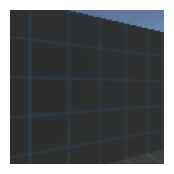

In [ ]:
#@title Формат собираемых данных { vertical-output: true }
#@markdown два луча: чисто детектор и вербальный. Визуальные см далее.
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
#@markdown Ray obs: [{one hot tg},{path is clear:bool},{distance(0-1) in max range, 1 if path is clear}]
env.step()
DS, TS = env.get_steps(env_name)
x = DS[0].obs[2]
plt.figure(figsize=(2, 2))
plt.axis("off")
plt.imshow(Image.fromarray((255*x).astype(np.uint8)))
TS.obs


In [ ]:
#@title Процедура Action_on_Decision для сбора датасета
import numpy as np
from mlagents_envs.environment import ActionTuple

def Action_on_Decision(DS,olds=None):
  act = ActionTuple()
  acto, oldo = [],[]
  k = 0
  for ray in DS.obs[0]:
    if ray[0] == 1:
      if olds and olds[k] == 3:
        probs=[0.02, 0.55, 0.03, 0.25, 0.05, 0.05, 0.05]
      elif olds and olds[k] == 4:
        probs=[0.02, 0.55, 0.03, 0.05, 0.25, 0.05, 0.05]
      else:
        probs=[0.02, 0.45, 0.03, 0.2, 0.2, 0.05, 0.05]
      a = np.random.choice(7, p=probs)
    else:
      if olds and olds[k] == 3:
        a = 3 #probs=[0.02, 0.15, 0.03, 0.5, 0.2, 0.05, 0.05]
      elif olds and olds[k] == 4:
        a = 4 #probs=[0.02, 0.15, 0.03, 0.2, 0.5, 0.05, 0.05]
      else:
        probs=[0.02, 0.15, 0.03, 0.35, 0.35, 0.05, 0.05]
        a = np.random.choice(7, p=probs)
    #probs=[0.02, 0.45, 0.03, 0.2, 0.2, 0.05, 0.05]
    #a = np.random.choice(7)
    if  a == 4  or (olds and olds[k] == 4 and a!=3):
      oldo.append(4)
    elif a == 3 or (olds and olds[k] == 3 and a!=4):
      oldo.append(3)
    else:
      oldo.append(0)
    acto.append(a)
    k = k + 1
  #print(acto,ray[0])
  acts = np.array(acto,np.int8)
  #acts = np.random.choice(7, len(DS),
  #         p=[0.05, 0.4, 0.05, 0.2, 0.2, 0.05, 0.05])
  acts = np.expand_dims(acts,axis=1)
  #act = spec.action_spec.empty_action(len(DS))
  act.add_discrete(acts)
  return act, oldo, acto

In [ ]:
# @title Сбор датасета { vertical-output: true }

import tqdm,torch
from torch import LongTensor, Tensor, argmax
#import matplotlib.pyplot as plt
#from IPython.display import clear_output
from IPython.display import HTML
from subprocess import Popen, PIPE
from base64 import b64encode

steps = 360 #@param {type:"integer"}
fps = 24

p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec',
           'png', '-r', str(fps), '-i', '-', '-vcodec',
           'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p',
           '-crf', '17', '-preset', 'veryslow', 'video.mp4'], stdin=PIPE)

old = None
ac,tg,vs = [],[],[]
for i in tqdm.trange(steps):
  decision_steps, terminal_steps = env.get_steps(env_name)
  act, old, action = Action_on_Decision(decision_steps,old)
  #act, old = Action_on_Decision(decision_steps,old)
  ac.append(torch.unsqueeze(LongTensor(action), 0))
  tg.append(torch.unsqueeze(argmax(Tensor(decision_steps.obs[1][:,:-2]), dim=1), 0))
  #tg.append(torch.unsqueeze(
  #    (argmax(Tensor(decision_steps.obs[1][:,:-2]), dim=1)+1)
  #            *(1-LongTensor(decision_steps.obs[1][:,-2])), 0))
  vs.append(torch.unsqueeze(Tensor(np.rollaxis(decision_steps.obs[2], 3, 1)), 0))
  #print(tg,ac)
  env.set_actions(env_name,act)
  env.step()
  disp.grab().save(p.stdin, 'PNG')
p.stdin.close()
p.wait()

mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'''
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
''')

100%|██████████| 360/360 [08:19<00:00,  1.39s/it]


In [ ]:
tg # Semantic = ['-','Wall','Red','Green','Blue']

[tensor([[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]]),
 tensor([[1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,

In [ ]:
ac # Actions = ['No','Fwd','Bck','Rgt','Lft','Rsf','Lsf']

[tensor([[4, 3, 4, 1, 3, 3, 1, 5, 5, 2, 1, 5, 1, 1, 1, 1, 1, 1, 6, 3]]),
 tensor([[1, 3, 4, 2, 3, 3, 6, 4, 3, 2, 1, 1, 2, 1, 3, 1, 3, 1, 1, 1]]),
 tensor([[1, 1, 1, 1, 3, 1, 3, 6, 3, 4, 3, 2, 5, 4, 1, 1, 1, 1, 1, 1]]),
 tensor([[1, 4, 1, 5, 1, 1, 1, 1, 3, 1, 1, 4, 3, 1, 5, 6, 3, 4, 1, 1]]),
 tensor([[4, 1, 4, 1, 3, 6, 1, 1, 2, 4, 3, 1, 4, 4, 1, 3, 3, 1, 5, 3]]),
 tensor([[4, 0, 4, 6, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 3, 4, 1, 1]]),
 tensor([[4, 1, 1, 1, 1, 3, 1, 1, 3, 0, 1, 4, 3, 1, 1, 1, 3, 6, 4, 3]]),
 tensor([[4, 4, 1, 3, 1, 1, 5, 4, 3, 1, 3, 4, 1, 1, 5, 1, 3, 1, 4, 1]]),
 tensor([[4, 4, 4, 3, 1, 1, 3, 1, 5, 1, 3, 4, 1, 1, 1, 5, 3, 2, 1, 1]]),
 tensor([[4, 4, 5, 3, 1, 3, 1, 1, 3, 1, 6, 4, 3, 1, 1, 1, 5, 1, 6, 1]]),
 tensor([[4, 4, 1, 3, 1, 1, 1, 1, 1, 1, 3, 4, 1, 1, 1, 3, 3, 0, 1, 1]]),
 tensor([[4, 4, 3, 4, 3, 1, 1, 4, 1, 4, 3, 4, 1, 1, 2, 3, 3, 1, 1, 1]]),
 tensor([[4, 4, 1, 3, 1, 1, 5, 4, 1, 1, 1, 4, 6, 4, 1, 1, 2, 1, 4, 3]]),
 tensor([[4, 4, 5, 1, 1, 5, 1, 4, 6, 3, 2, 4, 1, 4,

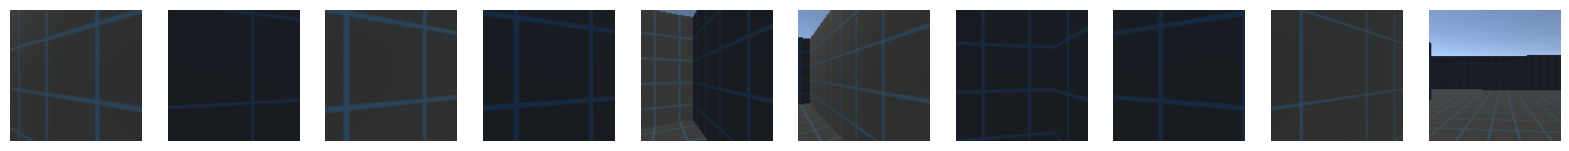

In [ ]:
import matplotlib.pyplot as plt

DS, TS = env.get_steps(env_name)
plt.figure(figsize=(20, 40))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis("off")
    plt.imshow(DS[i].obs[2])

plt.show();

In [ ]:
disp.stop(); env.close()